In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import math
import random
from tqdm.notebook import tqdm

In [2]:
def golden(func, limits, eps):
    a, b = limits
    
    flag = 0
    
    iteration = 0
    evaluation = 0
    
    while abs(a - b) >= eps:
        iteration += 1
        
        delta = (3 - math.sqrt(5)) * (b - a) / 2
        
        if flag == 0:
            evaluation += 2
            x1, x2 = a + delta, b - delta
            f1, f2 = func( x1 ), func( x2 )
        if flag == "x2=x1":
            evaluation += 1
            x1, x2 = a + delta, x1
            f1, f2 = func( x1 ), f1
        if flag == "x1=x2":
            evaluation += 1
            x1, x2 = x2, b - delta
            f1, f2 = f2, func( x2 )

        if f1 <= f2:
            b = x2
            flag = 'x2=x1'
        else:
            a = x1
            flag = 'x1=x2'
           
    min_x = (a + b) / 2
    min_y = (f1 + f2)  / 2
    
    return min_x, min_y, iteration, evaluation


def gradient_descent(
    gradient, start, learn_rate, n_iter=50, tolerance=1e-06
):
    vector = start
    iteration = 0
    for _ in tqdm(range(n_iter)):
        iteration += 1
        diff = -learn_rate * gradient(vector)
        if np.all(np.abs(diff) <= tolerance):
            print("Criterion stop, iterations = ", iteration)
            break
        vector += diff
    return vector


def conjugate_gradient(loss, gradient, start, tol=1e-3, max_iter=1000):
    vector = start
    diff = -gradient(vector)
    
    def alpha_min(alpha, func, diff, vector):
        return func(vector + alpha * diff)
    
    f_min = lambda alpha: alpha_min(alpha, loss, diff, vector)
    alpha = golden(f_min, limits=(1e-3, 1e1), eps=1e-3)[0]
    vector += alpha * diff
    diff0 = diff
    iterations = 0
    
    for _ in tqdm(range(max_iter)):
        iterations += 1
        diff = -gradient(vector)
        betta = diff.T * diff / diff0.T / diff0
        
        diff += betta * diff0
        if np.all( np.abs(diff) <=  tol):
            print("Criterion stop, iterations = ", iterations)
            break
            
        alpha = golden(f_min, limits=(1e-3, 1e1), eps=1e-3)[0]
        
        vector += alpha * diff
        diff0 = diff
        
    return vector

In [3]:
np.random.seed(1000)
a, b = random.random(), random.random()

max_x = 100

x = np.arange(0, max_x + 1, 1) / 100
y = a * x + b + np.random.normal(0, 1, size = len(x))

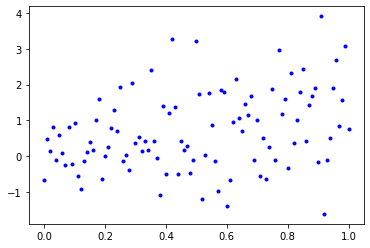

In [4]:
plt.plot(x, y, '.b')

In [19]:
def f_linear(x, a, b):
    return a * x + b

def f_rational(x, a, b):
    return a / ( 1 + b * x )

def least_squares(ab):
    a, b = ab
    global x, y
    global func
    return np.sum( (func(x, a, b) - y)**2)

def least_squares_lin_der(ab):
    a, b = ab
    global x, y
    return np.array([np.sum(2 * x * (b + a * x - y)), np.sum(2 * (b + a * x - y))])

def least_squares_rat_der(ab):
    a, b = ab
    global x, y
    return np.array([np.sum((a/(1+b*x) - y)*2/(1+b*x)), np.sum(2*a*x/(1+b*x)**2 * (a/(1+b*x)-y))])


def least_squares_rat_hess(ab):
    a, b = ab
    global x, y
    H = np.ones((2, 2))
    H[0, 0] = np.sum(2 / (1+b*x)**2)
    H[1, 1] = np.sum(2 * a**2 * x**2 / (1+b*x)**4 * 4 * a * x**2 * (a/(1+b*x)-y) / (1+b*x)**3)
    H[0, 1] = np.sum(-2*a*x/(1+b*x)**3-2*x*(a/(1+b*x)-y) / (1+b*x)**2)
    H[1, 0] = np.sum(-2*a*x/(1+b*x)**3-2*x*(a/(1+b*x)-y)/(1+b*x)**3)
    return H

def least_squares_lin_hess(ab):
    a, b = ab
    global x, y
    H = np.ones((2, 2))
    H[0, 0] = np.sum(2 * x**2)
    H[1, 1] = 2
    H[0, 1] = np.sum(2 * x)
    H[1, 0] = np.sum(2 * x)
    return H

def least_squares_lm(ab):
    a, b = ab
    global x, y
    global func
    return ( (func(x, a, b) - y)**2)

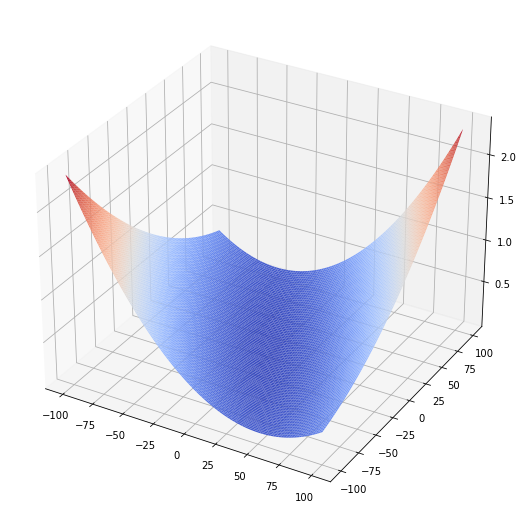

In [6]:
from matplotlib import cm

func = f_linear

X = np.linspace(-100, 100, 100)
Y = np.linspace(-100, 100, 100)

Z = np.ones((X.shape[0], Y.shape[0]))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        Z[i, j] = least_squares([X[i], Y[j]])

X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

In [7]:
# Gradient Descent

ab_init = np.array([10., 10.])

func = f_rational
result_rat_gd = gradient_descent(least_squares_rat_der, ab_init, learn_rate=3e-4, n_iter=1500, tolerance=1e-3)

func = f_linear
result_lin_gd = gradient_descent(least_squares_lin_der, ab_init, learn_rate=3e-4, n_iter=1500, tolerance=1e-3)


  0%|          | 0/1500 [00:00<?, ?it/s]

Criterion stop, iterations =  612


  0%|          | 0/1500 [00:00<?, ?it/s]

Criterion stop, iterations =  639


In [8]:
result_lin_gd

array([0.94616815, 0.23153207])

In [9]:
# conjugate_gradient

ab_init = np.array([1., 1.])

func = f_rational
result_rat_cg = conjugate_gradient(least_squares, least_squares_rat_der, start=ab_init, max_iter=10000)

func = f_linear
result_lin_cg = conjugate_gradient(least_squares, least_squares_lin_der, start=ab_init, max_iter=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Criterion stop, iterations =  153


In [10]:
# Newton

ab_init = np.array([1., 1.])
func = f_linear
result_lin_newton = optimize.minimize(least_squares, ab_init, method="Newton-CG", jac=least_squares_lin_der, 
                                  hess=least_squares_lin_hess, options={'xtol': 1e-3, 'disp':True})

func = f_rational
result_rat_newton = optimize.minimize(least_squares, ab_init, method="Newton-CG", jac=least_squares_rat_der, 
                                  hess=least_squares_rat_hess, options={'xtol': 1e-3, 'disp':True})

Optimization terminated successfully.
         Current function value: 110.599303
         Iterations: 33
         Function evaluations: 36
         Gradient evaluations: 36
         Hessian evaluations: 33
         Current function value: 134.018438
         Iterations: 1
         Function evaluations: 22
         Gradient evaluations: 10
         Hessian evaluations: 2


In [24]:
# Levenberg-Marquardt algorithm (LMA)

ab_init = np.array([1., 1.])
func = f_linear
result_lin_lma = optimize.least_squares(least_squares_lm, ab_init, method="lm")

func = f_rational
result_rat_lma = optimize.least_squares(least_squares_lm, ab_init, method="lm")

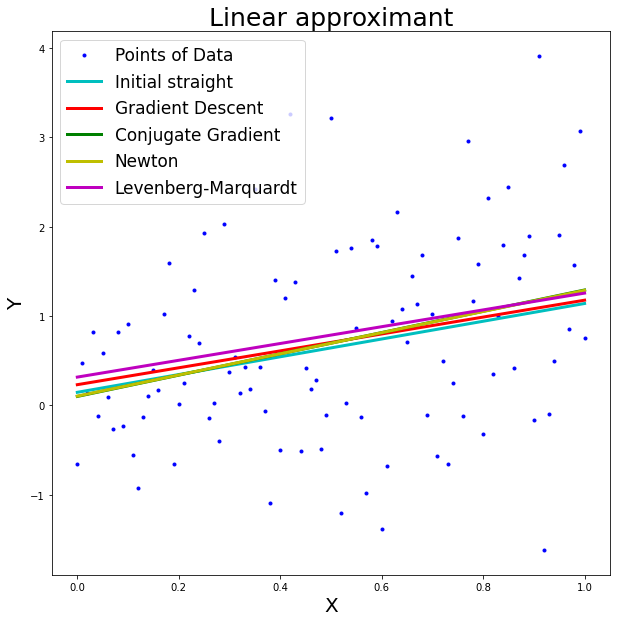

In [26]:
plt.figure(figsize=(10,10))
plt.title("Linear approximant", fontsize=25)
plt.plot(x, y, '.b', label="Points of Data")
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.plot(x, a * x + b, 'c', label="Initial straight", linewidth=3)
plt.plot(x, f_linear(x, result_lin_gd[0], result_lin_gd[1]), 'r', label="Gradient Descent", linewidth=3)
plt.plot(x, f_linear(x, result_lin_cg[0], result_lin_cg[1]), 'g', label="Conjugate Gradient", linewidth=3)
plt.plot(x, f_linear(x, result_lin_newton.x[0], result_lin_newton.x[1]), 'y', label="Newton", linewidth=3)
plt.plot(x, f_linear(x, result_lin_lma.x[0], result_lin_lma.x[1]), 'm', label="Levenberg-Marquardt", linewidth=3)
plt.legend(fontsize=17)  

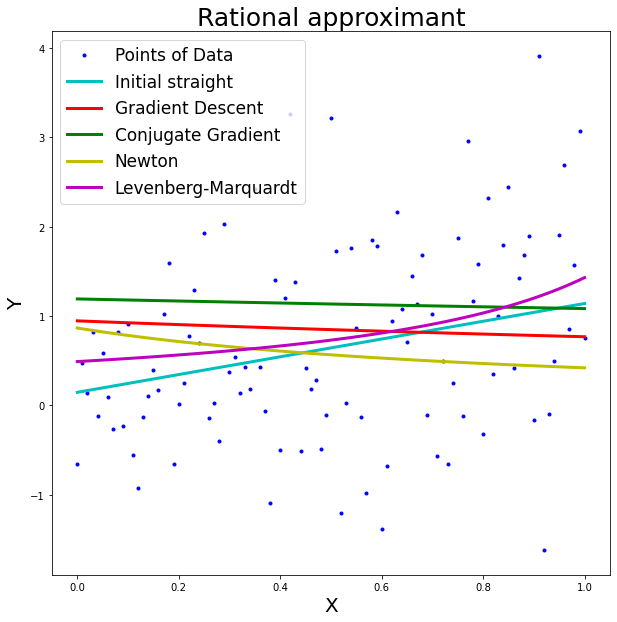

In [27]:
plt.figure(figsize=(10,10))
plt.title("Rational approximant", fontsize=25)
plt.plot(x, y, '.b', label="Points of Data")
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.plot(x, a * x + b, 'c', label="Initial straight", linewidth=3)
plt.plot(x, f_rational(x, result_rat_gd[0], result_rat_gd[1]), 'r', label="Gradient Descent", linewidth=3)
plt.plot(x, f_rational(x, result_rat_cg[0], result_rat_cg[1]), 'g', label="Conjugate Gradient", linewidth=3)
plt.plot(x, f_rational(x, result_rat_newton.x[0], result_rat_newton.x[1]), 'y', label="Newton", linewidth=3)
plt.plot(x, f_rational(x, result_rat_lma.x[0], result_rat_lma.x[1]), 'm', label="Levenberg-Marquardt", linewidth=3)
plt.legend(fontsize=17)